In [ ]:
# Dependencies for entire notebook here
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [159]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz


Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Benchmark CNN (for testing)

Based on challenge requirements, building model using tensorflow low-level API

In [162]:
# To run nicely in jupyter notebook
sess = tf.InteractiveSession()

c:\users\alonh\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [163]:
# Functions for creating weights and biases
# https://www.tensorflow.org/get_started/mnist/pros
def weight_variable(shape, name=None):    
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

# Functions for convolution and pooling functions
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME', name=name)

def max_pooling_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=name)

In [164]:
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784], name='xOriginal')
y_ = tf.placeholder(tf.float32, shape=[None, 10], name='yOriginal')

Benchmark model to be used for testing classification on real images with and without noise

In [165]:
# y = (Wx +b)
# https://www.tensorflow.org/get_started/mnist/pros

# Input layer
x_image = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32], name="W_conv1")
b_conv1 = bias_variable([32], name="b_conv1")
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name="x_conv1")
x_pool1 = max_pooling_2x2(x_conv1, name="x_pool1")

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64], name="W_conv2")
b_conv2 = bias_variable([64], name="b_conv2")
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2, name="x_conv2")
x_pool2 = max_pooling_2x2(x_conv2, name="x_pool2")

# Flatten - keras 'flatten'
x_flat = tf.reshape(x_pool2, [-1, 7*7*64], name="x_flat")

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024], name="W_fc1") # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024], name="b_fc1")
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1, name="x_fc1")

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10], name="W_fc2")
b_fc2 = bias_variable([10], name="b_fc2")
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [166]:
# Probabilities - output from model (not the same as logits)
y = tf.nn.softmax(y_conv)

In [167]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [168]:
# Setup to test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [169]:
# Initilize all global variables
sess.run(tf.global_variables_initializer())

In [170]:
# Train model
# Run once to get the model to a good confidence level
# was 1000
for i in range(1000):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})


step 0, training accuracy 0.09


In [171]:
# Run trained model against test data
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  y_: mnist.test.labels[0:500], keep_prob: 1.0}))


test accuracy 0.86


In [172]:
def create_predictions(image_list):
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pct_list = np.zeros(len(image_list))
    pred_list = np.argmax(prob, axis=1)
    for i in range(len(prob)):
        pct_list[i] = prob[i][pred_list[i]]
        
    return pred_list, pct_list


In [173]:
def plot_predictions(image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None


In [174]:
# Get 10 2s [:,2] from top 500 [0:500], nonzero returns tuple, get index[0], then first 10 [0:10]
index_of_2s = np.nonzero(mnist.test.labels[0:500][:,2])[0][0:10]
x_batch = mnist.test.images[index_of_2s]

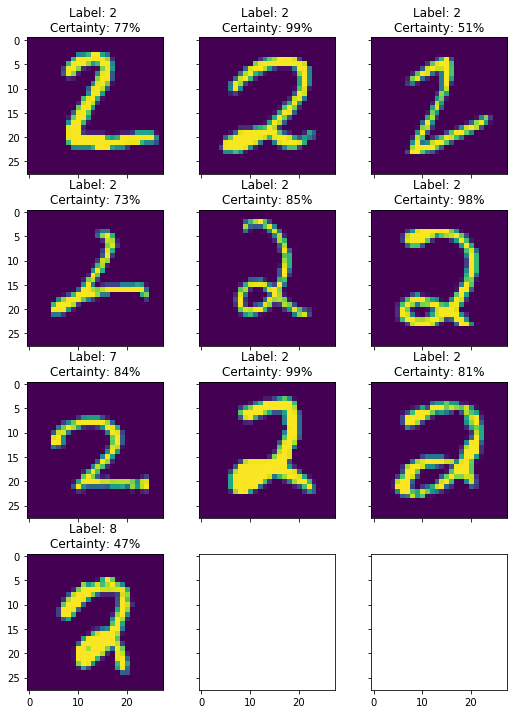

In [175]:
plot_predictions(x_batch)

All above 2s are correctly classified, although at varying degrees of certainty (mostly above 95%)

## Adversarial Images

Expand on benchmark model using low-level API. Create adversarial image of a 2 to be misclassified as a 6

In [176]:
# Mostly inspired by:
# https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture
def create_plot_adversarial_images(x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for _ in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image, keep_prob: 1.0}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
        
        # Create darray of 3 images - orig, noise/delta, adversarial
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)

        # Print/plot images and return probabilities
        probs = plot_predictions(img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
    
    return probs_per_step


In [177]:
def create_adversarial_image(x_image, y_label, lr=0.1, n_steps=1):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for i in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image, keep_prob: 1.0}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
        x_image = np.reshape(x_adv, (1, 784))
        
    label, prob = create_predictions(x_image)
    return x_image, label, prob


In [178]:
# # Pick a random 2 image from first 1000 images 
# # Create adversarial image and with target label 6
# index_of_2s = np.nonzero(mnist.test.labels[0:1000][:,2])[0]
# rand_index = np.random.randint(0, len(index_of_2s))
# image_norm = mnist.test.images[index_of_2s[rand_index]]
# image_norm = np.reshape(image_norm, (1, 784))
# label_adv = [0,0,0,0,0,0,1,0,0,0] # one hot encoded, adversarial label 6


In [179]:
def create_specific_adversarial_image(originNumber, destinationNumber, n_steps=10):
    index_of_number = np.nonzero(mnist.test.labels[0:1000][:,originNumber])[0]
    rand_index = np.random.randint(0, len(index_of_number))
    image_norm = mnist.test.images[index_of_number[rand_index]]
    image_norm = np.reshape(image_norm, (1, 784))    
    label_adv = np.zeros(10).astype(int) # one hot encoded
    label_adv[destinationNumber] = 1;
    adv_image, label, prob = create_adversarial_image(image_norm, label_adv, lr=0.2, n_steps=n_steps)
    return adv_image, label, prob

In [180]:
def generate_trainSet():
    number_of_examples_per_number = 1;
    original_number = np.zeros(shape=(1, 1))
    original_number = np.delete(original_number, 0, 0)
    target_number = np.zeros(shape=(1, 10))
    target_number = np.delete(target_number, 0, 0)
    prob_list = np.zeros(shape=(1, 1))
    prob_list = np.delete(prob_list, 0, 0)
    adv_img_list = np.zeros(shape=(1, 784))
    adv_img_list = np.delete(adv_img_list, 0, 0)
    for origin in range(2):
        for p in range(number_of_examples_per_number):
            for target in range(2):
                if origin != target:
                    prob = 0
                    label = origin
                    n_steps = 10
                    while prob < 0.9 or label != target:
                        adv_image, label, prob = create_specific_adversarial_image(origin, target, n_steps)
                        prob = prob[0]
                        label = label[0]
                        print("-", end="", flush=True)
                        
                        #print((origin, target, label, prob, n_steps), end="", flush=True)                        
                        #print(" X ")
                        n_steps = n_steps + 2
                    original_number = np.append(original_number, origin)
                    target_to_add = np.zeros(shape=(1,10))
                    target_to_add[0][target] = 1 #to vectorize the labeling
                    target_number = np.concatenate((target_number, target_to_add), axis=0)
                    prob_list = np.append(prob_list, prob)
                    #the action of concation can be i,proved
                    adv_img_list = np.concatenate((adv_img_list, adv_image), axis=0)
                    print("|", end="", flush=True)
        print("Number")            
        #print(original_number, target_number, prob_list)
    return original_number, target_number, prob_list, adv_img_list


def generate_adversarial_and_save():
    original_number, target_number, prob_list, adv_img_list = generate_trainSet()
    np.save('original_number.npy', original_number)
    np.save('target_number.npy', target_number)
    np.save('prob_list.npy', prob_list)
    np.save('adv_img_list.npy', adv_img_list)
    
    
def load_saved_adversarial():    
    original_number = np.load('original_number.npy')
    target_number = np.load('target_number.npy')
    prob_list = np.load('prob_list.npy')
    adv_img_list = np.load('adv_img_list.npy')
    return original_number, target_number, prob_list, adv_img_list


In [181]:
original_number, target_number, prob_list, adv_img_list = generate_trainSet()



-

|

-

|

Number


-

-

|

-

|

Number


-

|

-

-

|

Number


In [182]:
# uniting and shuffeling between adv inputs and benign
# creating labels as 2d array which [0,1] is adv
number_of_adv_images = adv_img_list.shape[0]
adv_label = np.zeros(number_of_adv_images)
adv_label = np.c_[adv_label, np.ones(number_of_adv_images)]

number_of_benign = 1000
benign_label = np.ones(number_of_benign)
benign_label = np.c_[benign_label, np.zeros(number_of_benign)]
# uniting adv and benign
united_labels = np.concatenate((adv_label, benign_label), axis=0)
united_images = np.concatenate((adv_img_list, mnist.train.images[0:number_of_benign]), axis=0)
united_images_and_labels = np.c_[united_images, united_labels]
np.random.shuffle(united_images_and_labels)
#add precondition
images_data, labels_data = np.hsplit(united_images_and_labels, [united_images_and_labels.shape[1]-2])
train_size = 700
image_train_data, image_test_data = np.split(images_data, [train_size])
label_train_data, label_test_data = np.split(labels_data, [train_size])

In [183]:
# reset and restore old variables
local_path = "C:\\Users\\alonh\Documents\\Thesis\\MNIST-adversarial-images\\original-nn-data.ckpt"
# Initilize all global variables
# sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, local_path)
saver = None
tf.reset_default_graph()
sess.close()
sess = tf.InteractiveSession()
W_conv1 = tf.get_variable("W_conv1", shape=W_conv1.shape)
b_conv1 = tf.get_variable("b_conv1", shape=b_conv1.shape)
W_conv2 = tf.get_variable("W_conv2", shape=W_conv2.shape)
b_conv2 = tf.get_variable("b_conv2", shape=b_conv2.shape)
saver = tf.train.Saver(var_list={'W_conv1': W_conv1, 'b_conv1': b_conv1, 'W_conv2': W_conv2, 'b_conv2': b_conv2})
saver.restore(sess, "C:\\Users\\alonh\Documents\\Thesis\\MNIST-adversarial-images\\original-nn-data.ckpt")

INFO:tensorflow:Restoring parameters from C:\Users\alonh\Documents\Thesis\MNIST-adversarial-images\original-nn-data.ckpt


c:\users\alonh\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [184]:
# Create placeholders nodes for images and label inputs
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784], name='xDetector')
y_ = tf.placeholder(tf.float32, shape=[None, 2], name='yDetector')


In [ ]:
# modified nn based on original
to_initialize = []
# Input layer
x_image_new = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# # Conv layer 1 - 32x5x5 - using same weights and biases as the pretrained
# W_conv1 = weight_variable([5, 5, 1, 32])
# b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image_new, W_conv1) + b_conv1, name="x_conv1_new")
x_pool1 = max_pooling_2x2(x_conv1, name="x_pool1_new")
# Conv detector layer 1  - 32x5x5
W_conv1_detector = weight_variable([5, 5, 32, 32], name="W_conv1_detector")
b_conv1_detector = bias_variable([32], name="b_conv1_detector")
x_conv1_detector = tf.nn.relu(conv2d(x_pool1, W_conv1_detector) + b_conv1_detector, name="x_conv1_detector")
x_pool1_detector = max_pooling_2x2(x_conv1_detector, name="x_pool1_detector")

# # Conv layer 2 - 64x5x5
# W_conv2 = weight_variable([5, 5, 32, 64])
# b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2, name="x_conv2_new")
x_pool2 = max_pooling_2x2(x_conv2, name="x_pool2_new")

# stacking conv2 output and x_pool1 detector output
conv_detector_2_input = tf.concat([x_conv2, x_pool1], 3)


# Conv detector layer 2 - 64x5x5
W_conv2_detector = weight_variable([5, 5, 96, 64], name="W_conv2_detector")
b_conv2_detector = bias_variable([64], name="b_conv2_detector")
x_conv2_detector = tf.nn.relu(conv2d(conv_detector_2_input, W_conv2_detector) + b_conv2_detector, name="x_conv2_detector")
x_pool2_detector = max_pooling_2x2(x_conv2_detector, name="x_pool2_detector")
# Flatten - keras 'flatten'
pool_shape = x_pool2_detector.shape
shape_size = (pool_shape[1]*pool_shape[2]*pool_shape[3]).value
x_flat_detector = tf.reshape(x_pool2_detector, [-1, shape_size], name="x_flat_detector")


W_fc1_detector = weight_variable([shape_size, 1024], name="W_fc1_detector") # max pooling reduced image to 7x7
b_fc1_detector = bias_variable([1024], name="b_fc1_detector")
x_fc1_detector = tf.nn.relu(tf.matmul(x_flat_detector, W_fc1_detector) + b_fc1_detector, name="x_fc1_detector")

# Regularization with dropout
keep_prob_detector = tf.placeholder(tf.float32, name="keep_prob_detector")
x_fc1_drop_detector = tf.nn.dropout(x_fc1_detector, keep_prob_detector, name="x_fc1_drop_detector")


# Classification layer
W_fc2_detector = weight_variable([1024, 2], name="W_fc2_detector")
b_fc2_detector = bias_variable([2], name="b_fc2_detector")
y_conv= tf.matmul(x_fc1_drop_detector, W_fc2_detector) + b_fc2_detector


In [203]:
# Probabilities - output from model (not the same as logits)
# CHANGE!!-----------------------------------------------------------------
y = tf.nn.softmax(y_conv, name="y_new")

In [204]:
# Loss and optimizer
cross_entropy2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv), name="cross_entropy2")
# add variables to optimize here:
var_list = [W_conv1_detector, W_conv2_detector, W_fc2_detector]
train_step2 = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy2, var_list=var_list, name="train_step2")

In [205]:
# Setup to test accuracy of model
correct_prediction2 = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1), name="correct_prediction2")
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, tf.float32), name="accuracy2")


In [ ]:
def initialize_uninitialized_global_variables(sess):
    """
    Only initializes the variables of a TensorFlow session that were not
    already initialized.
    :param sess: the TensorFlow session
    :return:
    """
    # List all global variables
    global_vars = tf.global_variables()

    # Find initialized status for all variables
    is_var_init = [tf.is_variable_initialized(var) for var in global_vars]
    is_initialized = sess.run(is_var_init)

    # List all variables that were not initialized previously
    not_initialized_vars = [var for (var, init) in
                            zip(global_vars, is_initialized) if not init]
    for uninit in not_initialized_vars:
        print(not_initialized_vars)
    # Initialize all uninitialized variables found, if any
    if len(not_initialized_vars):        
        sess.run(tf.variables_initializer(not_initialized_vars)) 

initialize_uninitialized_global_variables(sess)


In [227]:
# Train model
# Run once to get the model to a good confidence level
batch_size = 100
batch_index = 0
image_train_size = image_train_data.shape[0]
number_of_steps = image_train_size / batch_size
for i in range(int(number_of_steps)):
    # if(batch_index>=image_train_data.shape[0]):
    #     print("reached limit of train data current index: ", batch_index, "data size: ", image_train_data.shape[0])
    #     break
    batch_image = image_train_data[batch_index: (batch_index + batch_size)]
    batch_label = label_train_data[batch_index: (batch_index + batch_size)]
    if i % 2 == 0:
        train_accuracy = accuracy2.eval(session=sess, feed_dict={x: batch_image, y_:batch_label, keep_prob_detector: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step2.run(feed_dict={x: batch_image, y_: batch_label, keep_prob_detector: 0.4})
    batch_index = batch_index + batch_size


step 0, training accuracy 1
step 2, training accuracy 1
step 4, training accuracy 1


step 6, training accuracy 0.98


In [228]:
# Run trained model against test data
print("test accuracy %g"%accuracy2.eval(session=sess, feed_dict={x: image_test_data, 
                                                  y_: label_test_data, keep_prob_detector: 1.0}))

test accuracy 0.996732


In [229]:
sess.close()